In [8]:
import numpy as np
import librosa
import os
import glob
import warnings
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import SparseCoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import SparseCoder
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler


In [9]:
# MFCC
def extract_features(audio_file, mfcc=13):
    signal, sample_rate = librosa.load(audio_file, sr=None)
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=mfcc)
    return mfcc.mean(axis=1)

In [28]:
# PLP
# !pip3.8 install sidekit
from sidekit.frontend.features import plp

def extract_features(audio_file, num_ceps=13):
    signal, sample_rate = librosa.load(audio_file, sr=None)
    plp_coeffs, _ = plp(signal, fs=sample_rate, rasta=True, num_ceps=num_ceps)
    return np.mean(plp_coeffs, axis=1)

In [33]:
import pywt
def extract_features(audio_file, wavelet='db4', level=4):
    signal, sample_rate = librosa.load(audio_file, sr=None)
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = np.concatenate([np.mean(c) for c in coeffs] + [np.std(c) for c in coeffs])
    return features

In [42]:
# Function to add Gaussian noise to the features
# def add_noise(features, noise_factor):
#     noise = np.random.randn(*features.shape) * noise_factor
#     return features + noise
def add_noise(features, noise_factor):
    noise = np.random.randn(*features.shape) * noise_factor * np.std(features)
    return features + noise


In [20]:
# train and prediction based on my own dataset
import re

def extract_name(file_name):
    # The regular expression pattern below matches any sequence of letters (a-z or A-Z)
    pattern = r'./.*/[a-zA-Z]+'
    match = re.search(pattern, file_name)
    parts = match.group(0).split('/')
    # Get the string after the second '/'
    string_after_second_slash = parts[2]
    
    if match:
        return string_after_second_slash
    else:
        return None

def load_dataset(dir):
    # Load dataset
    data_dir = dir
    all_speakers = []
    all_speakers.extend(os.listdir(data_dir))
    X, y = [], []
    audio_files = glob.glob(os.path.join(data_dir, '*.wav'))
    audio_files +=  glob.glob(os.path.join(data_dir, '*.WAV'))

    for audio_file in audio_files:
        features = extract_features(audio_file, 120)
        X.append(features)
        speaker = extract_name(audio_file)
        y.append(speaker)
        
    X, y = np.array(X), np.array(y)
    return X, y

X_train, y_train = load_dataset("./train")
X_test, y_test = load_dataset("./test")
dictionary = X_train.T

# print('Number of speakers:', len(np.unique(y_train)))
# print('Speakers:', np.unique(y_train))
# # improve robustness        
# identity_matrix = np.identity(X_train.shape[1])
# # print("Dictionary dimensions:", dictionary.shape)
# A_matrix = np.hstack((dictionary, identity_matrix))

# Sparse representation        
# Classification with Identity Matrix
coder = SparseCoder(dictionary.T, transform_algorithm='lasso_lars', transform_alpha=1.)
y_pred = []
for i, y in enumerate(X_test):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        x_est = coder.transform(y.reshape(1, -1))[0, :] # pinv(A)*y, estimated x

    residual = [
        np.linalg.norm(y - np.dot(
            dictionary[:, y_train == speaker][:, :len(X_train.T)], 
            x_est[:dictionary.shape[1]][y_train == speaker]))
        for speaker in np.unique(y_train)
    ]
    print('Number of speakers:', len(np.unique(y_train)))
    print(f"the residual of each speaker:\n{list(zip(np.unique(y_train),residual))}")
    print(residual)
    y_pred.append(np.unique(y_train)[np.argmin(residual)])

print(f"The speaker is {y_pred[0].capitalize()}")

Number of speakers: 6
the residual of each speaker:
[('SI', 476.6636), ('SX', 464.4651), ('dana', 467.2551), ('ekin', 543.04224), ('serene', 18.953722), ('zhenbo', 433.88828)]
[476.6636, 464.4651, 467.2551, 543.04224, 18.953722, 433.88828]
The speaker is Serene


In [12]:
# testing 
acc_list = []

for n_feature in range(50,51):
    acc = 0
    for k in range(3):
        
        # Load TIMIT dataset
        data_dir = 'TIMIT/data'
        train_dir = os.path.join(data_dir, 'TRAIN')

        # Select a random subset of speakers for training
        num_speakers_to_pick = 50  # Change this value to select a different number of speakers

        all_speakers = []
        dialects = os.listdir(train_dir)
        for dialect in dialects:
            if '.' not in dialect:
                speakers = os.listdir(os.path.join(train_dir, dialect))
                all_speakers.extend(speakers)

        selected_speakers = random.sample(all_speakers, num_speakers_to_pick)

#         print("Selected speakers:", selected_speakers)

        # Load dataset. Use 80% of the sentences of each speaker for training and 20% for testing
        X_train, y_train = [], []
        X_test, y_test = [], []

        dialects = os.listdir(train_dir)
        for dialect in dialects:
            if '.' not in dialect:
                speakers = os.listdir(os.path.join(train_dir, dialect))
            for speaker in speakers:
                if speaker not in selected_speakers:
                    continue
                audio_files = glob.glob(os.path.join(train_dir, dialect, speaker, '*.WAV'))
                np.random.shuffle(audio_files)
                num_sentences = len(audio_files)
                
                # Noise factor (adjust as needed)
                noise_factor = 0.0

                for i, audio_file in enumerate(audio_files):
                    features = extract_features(audio_file, n_feature)
                    # features = extract_features(audio_file, n_feature)

                    if i < num_sentences * 0.8:
                        X_train.append(features)
                        y_train.append(speaker)
                    else:
                        # Add noise to the features of the test data only
                        # noisy_features = add_noise(features, noise_factor)

                        X_test.append(features)
                        y_test.append(speaker)
                        
                # for i, audio_file in enumerate(audio_files):
                #     features = extract_features(audio_file,n_feature)
                #     if i < num_sentences * 0.8:
                #         X_train.append(features)
                #         y_train.append(speaker)
                #     else:
                #         X_test.append(features)
                #         y_test.append(speaker)

        gmm_speakers = {}
        for speaker in np.unique(y_train):
            speaker_mfcc = X_train[y_train == speaker]
            gmm = GaussianMixture(n_components=16, covariance_type='diag', random_state=42)
            gmm.fit(speaker_mfcc)
            gmm_speakers[speaker] = gmm

        # Add GMM scores to the training and testing features
        def add_gmm_scores(X, gmm_speakers):
            gmm_scores = np.zeros((X.shape[0], len(gmm_speakers)))
            for idx, (speaker, gmm) in enumerate(gmm_speakers.items()):
                gmm_scores[:, idx] = gmm.score_samples(X)
            return np.hstack((X, gmm_scores))

        X_train = add_gmm_scores(X_train, gmm_speakers)
        X_test = add_gmm_scores(X_test, gmm_speakers)
        
        # Convert to numpy arrays
        X_train, y_train = np.array(X_train), np.array(y_train)
        X_test, y_test = np.array(X_test), np.array(y_test)

        # Preprocessing
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        print('Number of speakers:', len(np.unique(y_train)))
        # improve robustness        
        identity_matrix = np.identity(X_train.shape[1])

        # Dictionary creation
        dictionary = X_train.T
        # print("Dictionary dimensions:", dictionary.shape)
        A_matrix = np.hstack((dictionary, identity_matrix))
        
        # Sparse representation        
        # Classification with Identity Matrix
        # coder = SparseCoder(A_matrix.T, transform_algorithm='lasso_lars', transform_alpha=1.)
        # y_pred = []
        # for i, y in tqdm(enumerate(X_test)):
        #     with warnings.catch_warnings():
        #         warnings.filterwarnings("ignore", category=ConvergenceWarning)
        #         x_est = coder.transform(y.reshape(1, -1))[0, :] # pinv(A)*y, estimated x

        #     residual = [
        #         np.linalg.norm(y - np.dot(
        #             dictionary[:, y_train == speaker][:, :len(X_train.T)], 
        #             x_est[:dictionary.shape[1]][y_train == speaker]))
        #         for speaker in np.unique(y_train)
        #     ]
        #     y_pred.append(np.unique(y_train)[np.argmin(residual)])

        # Classification without I
        coder = SparseCoder(dictionary.T, transform_algorithm='lasso_lars', transform_alpha=1.)
        y_pred = []
        for i, x in tqdm(enumerate(X_test)):
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning)
                sparse_representation = coder.transform(x.reshape(1, -1))[0,:]

            residual = [
                np.linalg.norm(x - np.dot(dictionary[:, y_train == speaker], sparse_representation[y_train == speaker])) 
                for speaker in np.unique(y_train)
            ]
            y_pred.append(np.unique(y_train)[np.argmin(residual)])

        # Evaluation
        print(f"{n_feature:} Accuracy: {accuracy_score(y_test, y_pred)}")

#         print("\nClassification Report:\n", classification_report(y_test, y_pred))
        acc += accuracy_score(y_test, y_pred)
     
    print(f"{n_feature:} Accuracy: {acc/3}")
    acc_list.append((n_feature,acc/3.0))

print(acc_list)

ValueError: Expected 2D array, got 1D array instead:
array=[-347.9201      58.86491    -36.757137    11.885873   -19.700096
  -19.12514    -15.764071   -14.595615   -12.369511     3.836306
  -18.323627     1.1805862   -3.952309    -1.3162032   -1.3599508
  -10.307747     6.6721554   -8.686648    -6.6645617    1.2320228
   -4.6395774   -6.1157837   -1.0681305   -2.7824721   -3.8245494
   -0.5347192   -4.23261     -2.3738697   -2.1120594   -2.392533
   -3.5720391   -1.2966589   -2.4582748   -4.0787516   -3.4510353
   -3.9927397   -1.4491609   -4.4285293   -2.895218    -4.3621535
   -4.2570353   -3.1657448   -3.9233768   -3.4163487   -0.7916542
    1.421422     6.0053167    8.053401    10.101147     8.781938 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

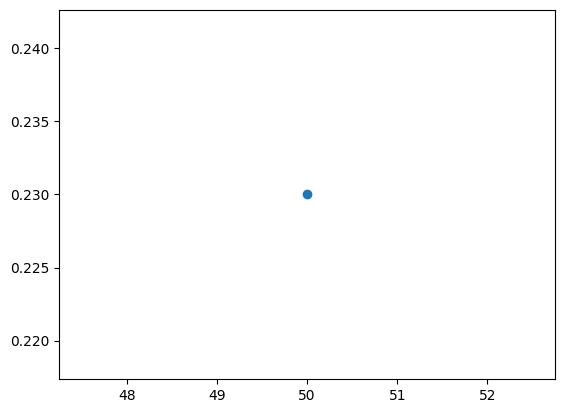

In [53]:
x,y = zip(*acc_list)
plt.plot(x,y,'o-')

In [15]:

# Dictionary creation
dictionary = X_train.T

# Sparse representation
coder = SparseCoder(dictionary.T, transform_algorithm='lasso_lars', transform_alpha=1.)

# Classification
y_pred = []
for i, x in tqdm(enumerate(X_test)):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sparse_representation = coder.transform(x.reshape(1, -1))[0,:]

    residual = [
        np.linalg.norm(x - np.dot(dictionary[:, y_train == speaker], sparse_representation[y_train == speaker])) 
        for speaker in np.unique(y_train)
    ]
    y_pred.append(np.unique(y_train)[np.argmin(residual)])
    # print(np.min(residual), y_pred[i], y_test[i])

# Evaluation
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


100it [00:00, 155.91it/s]

Accuracy: 0.90

Classification Report:
               precision    recall  f1-score   support

       FBLV0       0.67      1.00      0.80         2
       FBMJ0       1.00      0.50      0.67         2
       FDML0       1.00      1.00      1.00         2
       FEXM0       0.50      0.50      0.50         2
       FJKL0       1.00      0.50      0.67         2
       FJXP0       0.67      1.00      0.80         2
       FKAA0       1.00      1.00      1.00         2
       FMEM0       1.00      1.00      1.00         2
       FPMY0       1.00      1.00      1.00         2
       FRLL0       0.50      1.00      0.67         2
       FSBK0       1.00      1.00      1.00         2
       FTAJ0       1.00      1.00      1.00         2
       MAFM0       1.00      1.00      1.00         2
       MAKB0       0.50      1.00      0.67         2
       MARW0       1.00      1.00      1.00         2
       MBAR0       1.00      0.50      0.67         2
       MBBR0       1.00      1.00      1.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _w

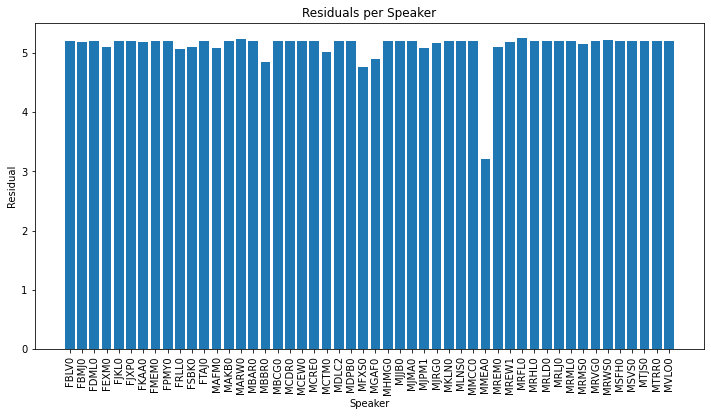

In [16]:
def plot_residuals(residuals, speakers, title='Residuals per Speaker'):
    plt.figure(figsize=(12, 6))
    plt.bar(speakers, residuals)
    plt.xlabel('Speaker')
    plt.ylabel('Residual')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()
plot_residuals(residual, np.unique(y_train))

<ipython-input-5-a7e00526c699>:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(sparse_representation, use_line_collection=True)


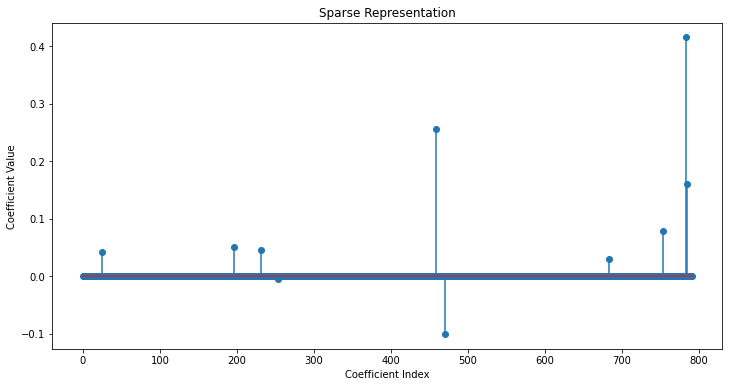

In [5]:
def plot_sparse_representation(sparse_representation, title='Sparse Representation'):
    plt.figure(figsize=(12, 6))
    plt.stem(sparse_representation, use_line_collection=True)
    plt.xlabel('Coefficient Index')
    plt.ylabel('Coefficient Value')
    plt.title(title)
    plt.show()

# Assuming you have a sparse_representation array
plot_sparse_representation(sparse_representation)